In [1]:
import requests
import pandas as pd
from vega_datasets import data
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import prepare
import modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

In [2]:
df = pd.read_csv('mfsnowcrab.csv')

In [3]:
df = df[df['cpue'] < 2000000]

In [4]:
df['year'] = pd.to_datetime(df['year'], format = '%Y')
df.dtypes

id                              int64
latitude                      float64
longitude                     float64
year                   datetime64[ns]
name                           object
sex                            object
bottom_depth                    int64
surface_temperature           float64
bottom_temperature            float64
haul                            int64
cpue                            int64
dtype: object

In [5]:
df_time = df[['year','cpue']]

In [6]:
df_time.head()

,year,cpue
0,1975-01-01,40356
1,1975-01-01,68691
2,1975-01-01,119748
3,1975-01-01,7882
4,1975-01-01,11258


In [7]:
df_time.shape

(17920, 2)

In [8]:
df_time = df_time.set_index('year')
df_time = df_time.sort_index()
df_time.head()

,cpue
year,
1975-01-01,40356
1975-01-01,314659
1975-01-01,258993
1975-01-01,1717
1975-01-01,4491


In [9]:
df_time = df_time.resample('y')['cpue'].mean()
df_time.shape

(44,)

In [10]:
train_len = int(0.6 *len(df_time))
val_test_split = int(0.8 * len(df_time))
train_len, val_test_split

(26, 35)

In [11]:
train = df_time.iloc[:train_len]
val = df_time.iloc[train_len: val_test_split]
test = df_time.iloc[val_test_split:]
train.shape, val.shape, test.shape

((26,), (9,), (9,))

In [16]:
train = pd.DataFrame(train)
val = pd.DataFrame(val)
test = pd.DataFrame(test)

In [17]:
val.head()

,cpue
year,
2001-12-31,19383.346939
2002-12-31,8276.072289
2003-12-31,15836.513158
2004-12-31,28370.948980
2005-12-31,35029.108466


<AxesSubplot:xlabel='year'>

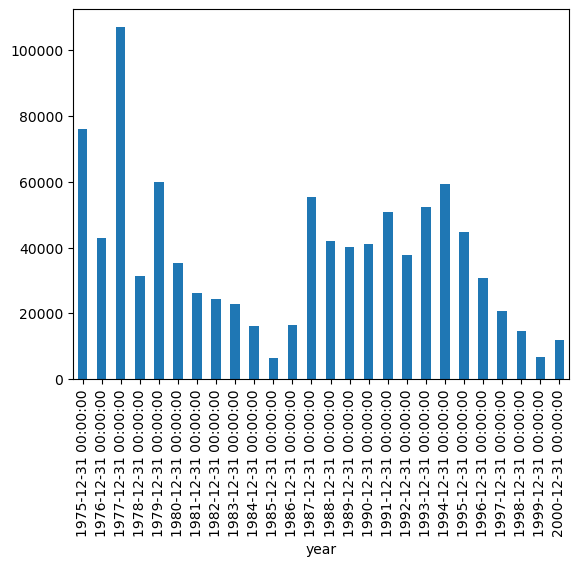

In [18]:
train.groupby('year')['cpue'].sum().plot.bar()

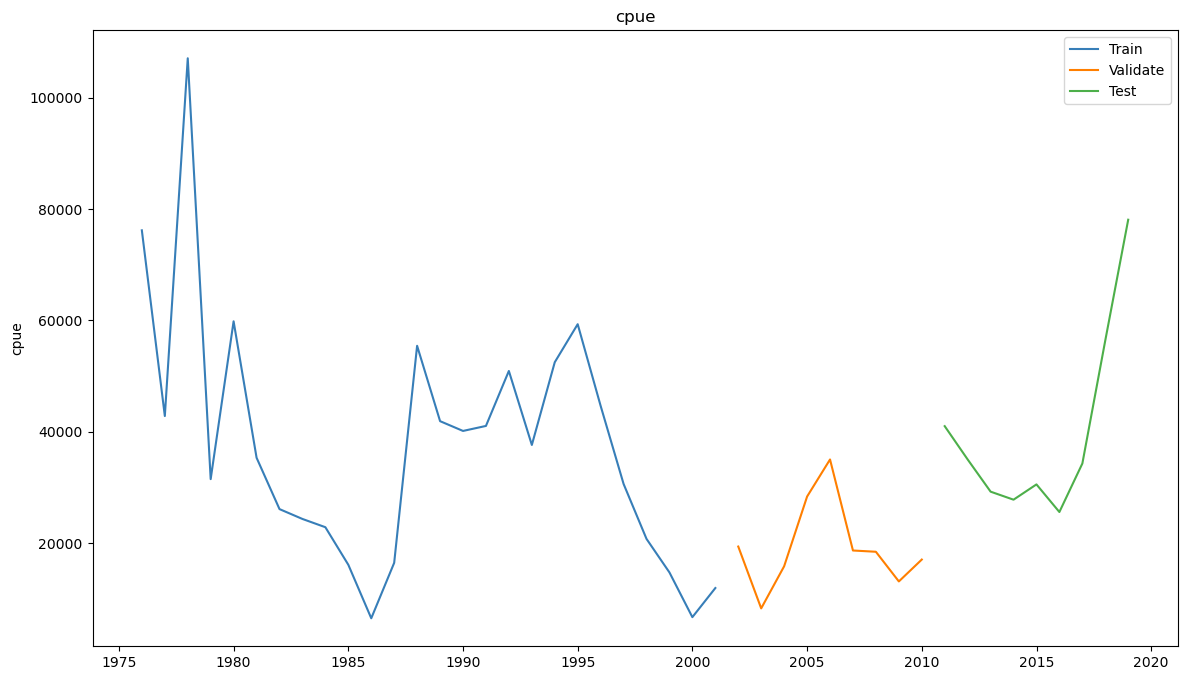

In [19]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(val[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [20]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


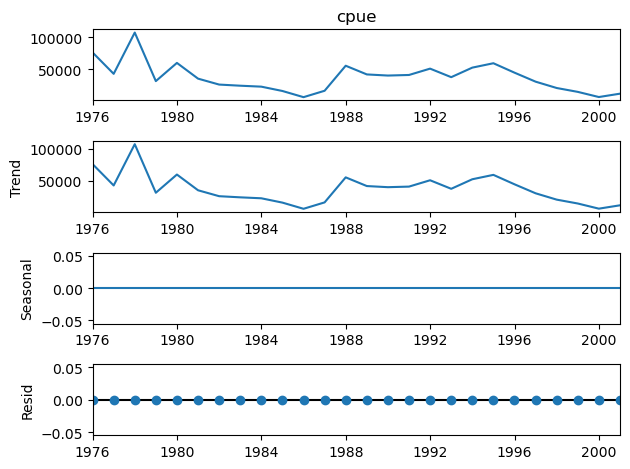

In [21]:
sm.tsa.seasonal_decompose(train['cpue'].resample('1y').mean()).plot()
None

In [22]:
baseline = round(train['cpue'].mean(), 4)

In [23]:
baseline

37446.3814

In [24]:
yhat_df = modeling.make_baseline_predictions(baseline, val)

In [25]:
yhat_df.head()

,cpue
year,
2001-12-31,37446.3814
2002-12-31,37446.3814
2003-12-31,37446.3814
2004-12-31,37446.3814
2005-12-31,37446.3814


cpue -- RMSE: 19589


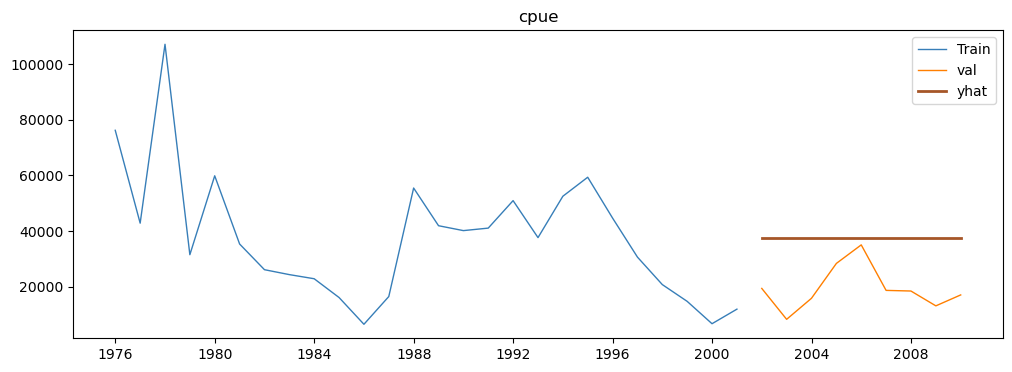

In [26]:
modeling.plot_and_eval('cpue', train, val, yhat_df)

In [27]:
eval_df = modeling.append_eval_df('simple_mean', col, val, yhat_df, eval_df)
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0


In [56]:
hst_cpue = ExponentialSmoothing(train.cpue, seasonal_periods=9, 
                                trend='add', seasonal='add', damped = True).fit()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [57]:
yhat_df = pd.DataFrame({'cpue': hst_cpue.forecast(val.shape[0])},
                          index=val.index)
yhat_df.head(20)

,cpue
year,
2001-12-31,9719.304090
2002-12-31,11562.712610
2003-12-31,-1056.161935
2004-12-31,7646.477973
2005-12-31,23348.488916
2006-12-31,18300.495821
2007-12-31,5686.491305
2008-12-31,-75.928286
2009-12-31,7160.516796


cpue -- RMSE: 12429


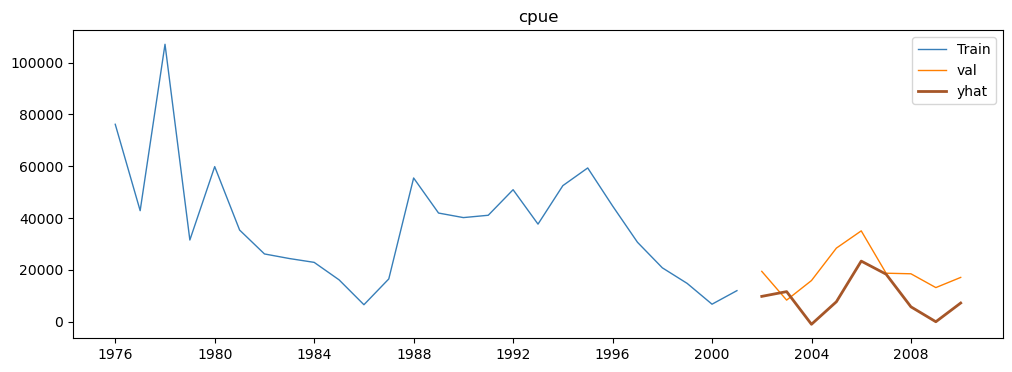

In [58]:
modeling.plot_and_eval(col, train, val, yhat_df)

In [59]:
eval_df = modeling.append_eval_df('holts_seasonal', col, val, yhat_df, eval_df)

In [60]:
eval_df

,model_type,target_var,rmse
0,simple_mean,cpue,19589.0
1,holts_seasonal,cpue,12429.0
